### Set-up

In [19]:
import logging
import os

import equinox as eqx
import jax
import jax.experimental.mesh_utils as mesh_utils
import jax.random as jr
import jax.sharding as sharding
import ml_collections
import numpy as np
import orbax.checkpoint as obx
import wandb
import os

from models import get_model, get_vae_fns
from utils import MetricComputer, get_loss_builder, get_translation_datasets

import matplotlib.pyplot as plt

In [2]:
workdir = 'runs'

from configs.base_uotfm import get_uotfm_config
from configs.celeba256.add_glasses.base_glasses import get_glasses_config
from configs.celeba256.base_celeba import get_celeba_config
from configs.celeba256.base_unet import get_unet_config
config = get_uotfm_config()
config = get_unet_config(config)
config = get_celeba_config(config)
config = get_glasses_config(config)

config.training.tau_a = 0.95
config.training.tau_b = 0.95
config.name = "celeba256-add-glasses-NoCond-Unified"

In [3]:
jax.config.update("jax_threefry_partitionable", True)
# create rng keys
key = jr.PRNGKey(config.seed)
np.random.seed(config.seed)
model_key, eval_key = jr.split(key, 2)
# set up sharding
num_devices = len(jax.devices())
# shard needs to have same number of dimensions as the input
devices = mesh_utils.create_device_mesh((num_devices, 1, 1, 1))
shard = sharding.PositionalSharding(devices)
if config.model.use_vae:
    logging.info("Loading VAE...")
    # load vae and jitted encode/decode functions
    vae_encode_fn, vae_decode_fn = get_vae_fns(shard)

In [4]:
# build model and optimization functions
model = get_model(config, config.model.input_shape, model_key)
loss_builder = get_loss_builder(config)
sample_fn = loss_builder.get_sample_fn()
# create checkpoint manager
mngr_options = obx.CheckpointManagerOptions(
    create=True, max_to_keep=3, best_fn=lambda metric: metric, best_mode="min"
)
ckpt_mngr = obx.CheckpointManager(
    directory=f"{os.getcwd()}/{workdir}/{config.name}/checkpoints",
    checkpointers=obx.Checkpointer(obx.PyTreeCheckpointHandler()),
    options=mngr_options,
)
# load saved checkpoint
if config.eval.checkpoint_step is not None:
    latest_step = config.eval.checkpoint_step
else:
    latest_step = ckpt_mngr.best_step()
print(f"Loading model from step {latest_step}...")

params, static = eqx.partition(model, eqx.is_array)


Loading model from step 75000...


In [56]:
# set up sharding
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1,1,1)) 
shard = sharding.PositionalSharding(devices)

In [73]:
params = jax.tree_util.tree_map(lambda x: jax.device_put(x, shard), params)
model = jax.tree_util.tree_map(lambda x: jax.device_put(x, shard) if eqx.is_array(x) else x, model)

In [74]:

# ! WE NEED THIS TO RESTORE THE MODEL, RIGHT NOW RANDOM WEIGHTS. See how to properly load it from checkpoint 
restored_ckpt = ckpt_mngr.restore(75_000, model)
#restored_params = eqx.filter(restored_ckpt, eqx.is_array)
#model = eqx.combine(restored_params, static)

inference_model = eqx.tree_inference(model, value=True)

/home/icb/pablo.acuavivahuerto/miniconda3/envs/uot-fm/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1250: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'shard_shape'

In [5]:
######
# Load dataset
config.data.nsamples = 256
if config.task == "translation":
    _, _, eval_src_ds, eval_tgt_ds = get_translation_datasets(
        config, shard, vae_encode_fn if config.model.use_vae else None
    )
    logging.info(f"num_eval_src: {eval_src_ds.length}")
    logging.info(f"num_eval_tgt: {eval_tgt_ds.length}")
elif config.task == "generation":
    eval_src_ds, eval_tgt_ds = None, None
####################

  0%|          | 0/2 [00:00<?, ?it/s]2024-06-11 12:22:14.018572: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 36.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-11 12:22:24.574734: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[128,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,256,256]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}, f32[128,128,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0} is taking a while...
2024-06-11 12:22:24.579358: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.004752487s
Trying algorithm

### Inference

In [49]:
import functools as ft
from typing import Any, Callable, Dict, List, Optional, Tuple

import diffrax as dfx
import equinox as eqx
import jax
import jax.random as jr
from utils import EasyDict

class FlowSolver:
    """Class for Flow Matching loss computation and sampling."""

    def __init__(
        self,
        t1: float,
        dt0: float,
        t0: float = 0.0,
        gamma: str = "constant",
        flow_sigma: Optional[float] = 0.1,
        weight: Optional[Callable[[float], float]] = lambda t: 1.0,
        solver: str = "tsit5",
        is_genot : bool = False 
    ):
        self.t1 = t1
        self.t0 = t0
        self.dt0 = dt0
        self.gamma = gamma
        self.sigma = flow_sigma
        self.weight = weight
        self.solver = solver
        self.is_genot = is_genot

    def get_sample_fn(self):
        """Get single sample function."""

        @eqx.filter_jit
        def single_sample_fn(model: eqx.Module, x0: EasyDict, key=None) -> jax.Array:
            """Produce single sample from the CNF by integrating forward."""

            def func(t, x_t, args, x0=x0): 
                film_cond = x0.get("embedding", None)
                cross_attn_cond=x0.data
                # TODO: Here we can try to force to with a lambda to get back towards out data point
                # In general we can make alpha(t) to try to paliate errors closer to the end, etc
                # alpha = 0.5
                alpha = 0 # jax.numpy.minimum(0.5, t**2)
                # Our traditional method is with alpha = 0
                #######################################################
                return (1-alpha)*model(t, x_t, 
                            film_cond=film_cond, 
                            cross_attn_cond=cross_attn_cond, 
                        ) + alpha * (x0.data-x_t)
            
            # --- 
            term = dfx.ODETerm(func)
            if self.solver == "tsit5":
                solver = dfx.Tsit5()
            elif self.solver == "euler":
                solver = dfx.Euler()
            elif self.solver == "heun":
                solver = dfx.Heun()
            else:
                raise ValueError(f"Unknown solver {self.solver}")
            if self.dt0 == 0.0:
                stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
                dt0 = None
            else:
                stepsize_controller = dfx.ConstantStepSize()
                dt0 = self.dt0
            
            if self.is_genot:
                src_data = jr.normal(key, shape=x0.data.shape)
            else:
                src_data = x0.data

            sol = dfx.diffeqsolve(
                term,
                solver,
                self.t0,
                self.t1,
                dt0,
                src_data,
                stepsize_controller=stepsize_controller,
            )
            return sol.ys[0], sol.stats["num_steps"]

        return single_sample_fn

fs = FlowSolver(
            t1=config.t1,
            dt0=config.dt0,
            flow_sigma=config.training.flow_sigma,
            gamma=config.training.gamma,
            weight=lambda t: 1.0,
            solver=config.solver,
            is_genot=config.training.is_genot
        )
sample_fn = fs.get_sample_fn()

In [50]:
# Get First 2 samples
x0 = next(iter(eval_src_ds))
x00 = x0.slice(25) # Get random element 

In [51]:
sol, nfe = sample_fn(inference_model, x00)

In [52]:
def build_img(vae_img):
    x00_decoded = vae_decode_fn(np.expand_dims(vae_img, axis=0))
    x00_image = x00_decoded[0].transpose(1,2,0)
    return np.clip(x00_image, -1.0, 1.0) * 0.5 + 0.5

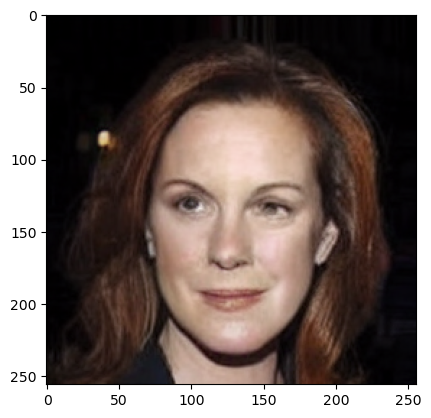

In [53]:
x00_image = build_img(x00.data)
plt.imshow(x00_image)

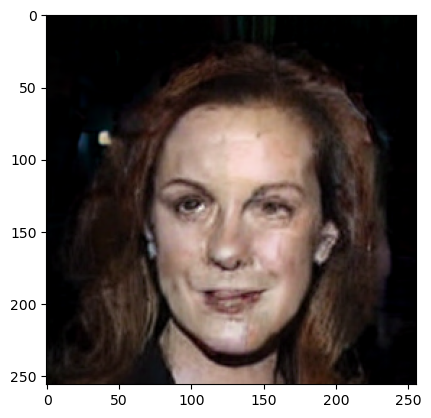

In [54]:
x00_sol = build_img(sol)
plt.imshow(x00_sol)

### Playing with Orbax

In [13]:
import numpy as np
import orbax.checkpoint as ocp
import jax

In [18]:
my_tree = {
    'a': np.arange(8),
    'b': {
        'c': 42,
        'd': np.arange(16),
    },
}
abstract_my_tree = jax.tree_util.tree_map(
    ocp.utils.to_shape_dtype_struct, my_tree)

In [19]:
abstract_my_tree

{'a': ShapeDtypeStruct(shape=(8,), dtype=int64),
 'b': {'c': 42, 'd': ShapeDtypeStruct(shape=(16,), dtype=int64)}}